<a href="https://colab.research.google.com/github/amenimtibaa/3D-Segmentation/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D part segmentation using PointNet**


> By Ameni Mtibaa and Tiphaine LE CLERCQ DE LANNOY



This Notebook is based on the [PointNet](https://arxiv.org/abs/1612.00593) architecture proposed by Charles R. Qi, Hao Su, Kaichun Mo, Leonidas J. Guibas. The original code in tensorflow can be found [here](https://github.com/charlesq34/pointnet). 

Before you start, make sure you download the data from [here](https://drive.google.com/drive/folders/13xccsa05YI3wwxL3csiddOYEeEJGOKib?usp=sharing) or execute the code "extract_data.py" and upload the files to your drive. 

Be sure to have the npy files in your current drive directory.

# *A gentle introduction to deep learning for point clouds*


## 1. Point Clouds

A point cloud is an important type of geometric data structure. It is the closest to 3D representation to raw sensor data and is in a canonical form. This means that we can convert it to other representations or other representations to point cloud. 
![](https://drive.google.com/uc?id=1ggr50f3xPVXhPVeL_WWaBq0daWX376tM )

**Fig 1. Example : stanford bunny point cloud**

We can use deep learning techniques to create predictive models on 3D. This is particulary useful for situations like self-driving cars, object classification, segmentation and medical predictions through radiotherapy images. 

## 2. Deep Learning on Point Clouds

### 2.1 Euclidean Data
Deep learning on 3D objects is quite new. Most work has focused on euclidean data. 
![](https://drive.google.com/uc?id=1YWnRYSSfP31IldDOA2mqTATqyFUaigj-)

**Fig 2. DL models on various Euclidean representations for 3D data**

### 2.2 Non-Euclidean Data
The issue however is that 3D point clouds are non-euclidean and do not have the gridded array structure where there is no global parametrization:
![](https://drive.google.com/uc?id=1TwZ0FKuy_T11lRYnHEKWhWYSD3dSNvZW)

**Fig 3. Various representations for 3D data: Euclidean representation (Descriptors, Projections, RGB-D, Volumetric; voxels and octree and multi-view) and Non-Euclidean representations (Point clouds, graphs and meshes)**

### 2.3 Non-Euclidean to Euclidean
This can be addressed by converting the point clouds into voxels (voxelisation). Once the point cloud has been converted into a voxel, a 3D-CNN can be applied. However, this diminishes important information about the 3D images that have been scanned, renders data unnecessarily voluminous and can cause issues:
![](https://drive.google.com/uc?id=12Prf2uh0xSZ6ZpVWpKZnzvrKRewwJRwZ)

**Fig 4. voxelisation example** 

Notice how the voxelised image of the rabbit now loses information regarding space around its ears. 

One model is Voxel 3D-CNN's (VoxNet's) Which requires large amounts of processing power that increase exponentially as sizes of the voxel grids increase.

Here, the pointnet approach comes handy.

## 3. PointNet Overview 

PointNet provides a unified architecutre for directly consuming points that can be used for classification, part-segmentation and scene semantic parsing. It was introduced by Charles Qi, Hao Su, Kaichun Mo and Leonidas Guibas from Stanford University in the paper: PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation in 2017. 

![](https://drive.google.com/uc?id=1W0p3Xi7r6ooCpd5gEA-VU3ssM6sskVZq)

### Main characteristics of PointNet: 
1. Directly consumes point cloud points = (x,y,z). 
2. It respects the permutation invariance of points in the input. Where permutation invariance  means that it does not assume any spatial relationships between the features (points cloud are permutation invariant because we can plot each point in any order and we would still have the same shape).
3. It also respects the transformation Invariance: outputs is unchanged if the object undergoes certain transformations, including rotation and translation.

### How does PointNet work? 
![](https://drive.google.com/uc?id=1hsqtt29K4c6hRACGE-XCzjSGp4QeXf1-)

The part segmentation network takes n points as input.
The first step is to apply input and feature transformations networks (T1 and T2 respectively).

Then, aggregates point features by max pooling and concatenate the output with the one-hot encoded vector indicating the class of the input. 
Finally, the latter vector is concatenated with skip links that able to collect local point features in different layers.

The model will output n*m scores for each of the n points and each of the m semantic subcategories (50 subcategories for shapenet) .

“mlp” stands for multi-layer perceptron, numbers in bracket are layer sizes. 

If we break this down, there are 8 steps to PointNet. They are: 
1. Input the data
2. Input transformation
3. MLP 1
4. Feature transformation
5. MLP2 
6. Global feature max-pooling
7. Point feature input
8. MLP prediction

In this notebook, we will reproduce this network using keras and the shapenet dataset.



# Lets import the necessary dependencies

In [2]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Reshape
from keras.layers import Conv1D, BatchNormalization, Dropout, GlobalMaxPooling1D
from keras.layers import Lambda, concatenate
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# For cool 3D interactive visualisations
import plotly.graph_objs as go
import plotly.express as px



TensorFlow 1.x selected.


Using TensorFlow backend.


# Input the data (and lets examine it). 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd drive/My\ Drive/pointnet/

/content/drive/My Drive/pointnet


In [0]:
train_points = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')

valid_points = np.load('val_data.npy')
valid_labels = np.load('val_label.npy')

Let's examine the data. 

In [5]:
print("Training shape: ", train_points.shape)
print("Test shape: \t", valid_points.shape)

Training shape:  (12137, 2048, 3)
Test shape: 	 (1870, 2048, 3)


The data is of shape: ( _n_ x number of points x coordinates (x,y,z) ). Here, we can see that we have 12137 samples in our training set and 1870 in our test with each sample (3D object) has 2048 points represented by an x,y,z coordinates.


Now let's plot some examples !

In [0]:
def plot_ply(file):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)
    x = file[:, 0]
    y = file[:, 1]
    z = file[:, 2]
    ax.scatter(x, y, z, marker='.', zdir='z')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

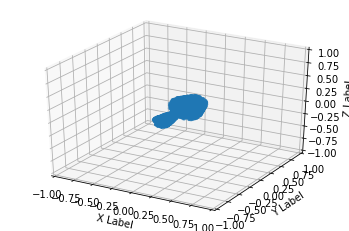

In [7]:
# extract 1 image from dataset
first_object = train_points[192]
# plot point cloud 
plot_ply(first_object)

Ok... so it looks like a.... I am not sure what it looks like, so lets look at it using an interactive 3D tool. 

In [8]:
# Define X,Y,Z vectors
X=first_object[:,0]
Y=first_object[:,1]
Z=first_object[:,2]

trace1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=10, color=Z, colorscale='Viridis', opacity=0.4))

data = [trace1]
layout = go.Layout(height=500, width=600)
fig = go.Figure(data=data, layout=layout)
fig.show()


well, it's a lamp :) 

# Lets build the model

### Input and Feature transform network : Tnet

The first transformation that occurs is called the input transformation (T-Net 1). This aligns the input point cloud as it can have arbitrary orientations. This is also known as an 'afine transformation'.
![](https://drive.google.com/uc?id=14WD-6abIL4RwuLZRGgFPzN8LgNszlU1k)

Input transformation network (T-Net1) is for predicting a transformation matrix to map a point cloud to canonical space before processing. A similar network is used to transform the features, the only difference is that the output corresponds to a 64x64 matrix (T-Net2).

The first transformation network is a mini-PointNet that takes raw point cloud as input and regresses to a 3 × 3 matrix. It’s composed of a shared MLP (64, 128, 1024) network, a max pooling across points and two fully connected layers with output sizes 512, 256. The output matrix is initialized as an identity matrix. All layers, except the last one, include ReLU and batch normalization. 

The second T-Net block is with the same idea, but this time for aligning in the embedding space. The embedding space essentially projects the features into a higher dimensional space so that the features are more alike and have a small distance between them in the embedded space.
The architecture is also different: bigger number of neurons and the output is a 64 × 64 matrix. 

In [0]:
def TNet(inputs, tsize, mlp_nodes=(64, 128, 1024), fc_nodes=(512, 256)):

    x = inputs
    for i, num_nodes in enumerate(mlp_nodes):
        x = Conv1D(filters=num_nodes, kernel_size=1, padding='VALID', strides=1, 
                   activation='relu')(x)
        x = BatchNormalization(momentum=0.99)(x)

    x = GlobalMaxPooling1D()(x)

    for i, num_nodes in enumerate(fc_nodes):
        x = Dense(num_nodes, activation='relu', use_bias=True, bias_initializer=keras.initializers.Zeros())(x)
        x = BatchNormalization(momentum=0.99)(x)

    x = Dense(tsize * tsize,
              weights=[np.zeros([num_nodes, tsize * tsize]), np.eye(tsize).flatten().astype(np.float32)])(x) 
    transformation_matrix = Reshape((tsize, tsize))(x)
    return transformation_matrix


### Features extraction : MLP

In [0]:
def multilayer_perceptron(inputs, mlp_nodes):
    '''
    Define multilayer-perceptron
    '''
    mlp = []
    x = inputs

    for i, num_nodes in enumerate(mlp_nodes):
        x = Conv1D(filters=num_nodes, kernel_size=1, padding='VALID', strides=1, 
                   activation='relu')(x)
        x = BatchNormalization(momentum=0.99)(x)
        #x = Dropout(0.2)(x)
        mlp.append(x)
    return mlp

### Put it all together

In [0]:
def extend_dimension(global_feature, axis):
    '''
    Extend dimension of a tensor(example: [None, 1024] to [None, 1, 1024])
    '''
    return tf.expand_dims(global_feature, axis)


def extend_size(global_feature, num_points):
    '''
    Extend size of a tensor(example: [None, 1, 1024] to [None, num_points, 1024])
    '''
    return tf.tile(global_feature, [1, num_points, 1])



def PointNetFull(num_points, num_classes):
    '''
    Pointnet full architecture
    :param num_points: an integer that is the number of input points
    :param num_classes: an integer that is number of categories
    '''

    inputs = Input(shape=(num_points, 3))

    tnet1 = TNet(inputs=inputs, tsize=3, mlp_nodes=(64, 128, 1024), fc_nodes=(512, 256))

    aligned_feature1 = keras.layers.dot(inputs=[inputs, tnet1], axes=2)

    extracted_feature11, extracted_feature12, extracted_feature13 = multilayer_perceptron(inputs=aligned_feature1,
                                                                                          mlp_nodes=(64, 128, 128))

    tnet2 = TNet(inputs=extracted_feature13, tsize=128, mlp_nodes=(256, 1024), fc_nodes=(512, 256))

    aligned_feature2 = keras.layers.dot(inputs=[extracted_feature13, tnet2], axes=2)


    extracted_feature21, extracted_feature22 = multilayer_perceptron(inputs=aligned_feature2, mlp_nodes=(512, 2048))

    global_feature = GlobalMaxPooling1D()(extracted_feature22)

    global_feature_seg = Lambda(extend_dimension, arguments={'axis': 1})(global_feature)

    global_feature_seg = Lambda(extend_size, arguments={'num_points': num_points})(global_feature_seg)


    # Segmentation block
    seg = concatenate(
        [extracted_feature11, extracted_feature12, extracted_feature13, aligned_feature2, extracted_feature21,
         global_feature_seg])

    seg1, seg2, seg3 = multilayer_perceptron(inputs=seg, mlp_nodes=(256, 256, 128))

    segmentation_result = Conv1D(num_classes, 1, padding='VALID', activation='softmax', bias_regularizer=keras.regularizers.l2(0.001))(seg3)

    model = Model(inputs=inputs, outputs=segmentation_result)

    return model



# Train !

first, let's define some data augmentation methods :) 

In [0]:
def rotate_point_cloud(batch_data):
    '''
    Randomly rotate the point cloud to augment the dataset, rotation is per
    shape based along up direction
    Input : B x N x 3 array, original batch of point clouds
    Returns : B x N x 3 array, rotated batch of point clouds
    '''

    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    '''
    Randomly jitter points, jittering is per point. 
    Input : B x N x 3 array, original batch of point clouds
    Returns : B x N x 3 array, jittered batch of point clouds
    '''
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data


Define model parameters

In [11]:
batch_size = 32
num_epoches = 15
# number of categories
num_classes = 51 #(from 1 to 51)
# number of points per point cloud
num_points = 2048
# learning rate
lr = 0.001
# Optimizer
opt = keras.optimizers.Adam(learning_rate= lr)
#opt = keras.optimizers.SGD(learning_rate= lr)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


One hot encode the labels

In [0]:
one_hot_train_labels = np_utils.to_categorical(train_labels, num_classes)
one_hot_valid_labels = np_utils.to_categorical(valid_labels, num_classes)

Compile

In [0]:
model = PointNetFull(num_points=num_points, num_classes=num_classes)
#print(model.summary())
model.compile(optimizer=opt,
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

Define checkpoint

In [0]:
checkpoint = ModelCheckpoint(
    filepath = "weights.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    # Save weights every 1 epochs.
    period=1
)

Define function to decay learning rate every 20 epochs

In [0]:
def decay_schedule(epoch, lr):
    # decay LR every 20 epochs
    if (epoch % 20 == 0) and (epoch != 0):
        lr = lr / 2
    return lr
    
lr_scheduler = LearningRateScheduler(decay_schedule)


Train

In [40]:
for epoch in range(num_epoches):

    # rotate and jitter point cloud in every epoch
    train_points_rotate = rotate_point_cloud(train_points)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    
    model.fit(train_points_jitter, one_hot_train_labels, 
              batch_size=batch_size, epochs=1,validation_split=0.2, 
              callbacks=[lr_scheduler, checkpoint], shuffle=True, verbose=1)
    

Train on 9709 samples, validate on 2428 samples
Epoch 1/1
9709/9709 [==============================] - 119s 12ms/step - loss: 0.9794 - accuracy: 0.7015 - val_loss: 6.2290 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 6.22897, saving model to weights.h5
Train on 9709 samples, validate on 2428 samples
Epoch 1/1
9709/9709 [==============================] - 114s 12ms/step - loss: 0.6368 - accuracy: 0.7960 - val_loss: 3.7319 - val_accuracy: 0.3682

Epoch 00001: val_loss improved from 6.22897 to 3.73187, saving model to weights.h5
Train on 9709 samples, validate on 2428 samples
Epoch 1/1
9709/9709 [==============================] - 114s 12ms/step - loss: 0.4998 - accuracy: 0.8372 - val_loss: 3.1499 - val_accuracy: 0.5841

Epoch 00001: val_loss improved from 3.73187 to 3.14994, saving model to weights.h5
Train on 9709 samples, validate on 2428 samples
Epoch 1/1
9709/9709 [==============================] - 114s 12ms/step - loss: 0.4540 - accuracy: 0.8495 - val_loss: 3.

# Evaluate and visualize

Test performance


In [0]:
model.load_weights('weights.h5')

In [18]:
score = model.evaluate(valid_points,one_hot_valid_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 

1870/1870 [==============================] - 7s 4ms/step
Test loss: 0.9101478997398825
Test accuracy: 0.8072589635848999


Select one test data to visualize


In [53]:
v_points = valid_points[639:640,:,:]
pred = model.predict(v_points)
pred = np.squeeze(pred)
v_points = np.squeeze(v_points)
pred = pred.tolist()

index = []
for i in range(v_points.shape[0]):
    index.append(np.argmax(pred[i]))
index = set(index)
dict={}
for c, i in enumerate(index):
  dict[i] = c 


colors = ['b', 'g', 'g', 'r', 'y', 'b']
m= ['o', 'v', '<', '>', '^', 'v']
c = []
for i in range(v_points.shape[0]):
    xs = v_points[i,0]
    ys = v_points[i,1]
    zs = v_points[i,2]
    ind = dict[np.argmax(pred[i])]
    c.append(colors[ind])

fig = px.scatter_3d(v_points, x=v_points[:,0], y=v_points[:,1], z=v_points[:,2], color=c)
fig.show()
      